# Lab 8: Variational Autoencoders

Name Nattapat Yuvasuta, 59070501028<br>



## Lab Instruction: Generate Random Handwriting Number

In this lab, you will learn do the generative model using variational autoencoder to generate random image.</br>

This is what we are going to do in this lab: https://www.siarez.com/projects/variational-autoencoder </br>
About the variational autoencoder: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

This lab, we created model using functional API > https://keras.io/models/model/ 

### Autoencoder Model

![autoencoder](autoencoder.jpg "Autoencoder")

### Variational Autoencoder Model

![VAE](autoencoder.png "Variational Autoencoder")

### Reconstruct image using Variational Autoencoder Model

![variation](variation.png "Variational Autoencoder")


***Images from:<br>***
*1. <a href=https://blog.keras.io/building-autoencoders-in-keras.html> Keras Blog </a></br>*
*2. Manning - Deep Learning with Python Book*


In [2]:
# Import required libraries
import keras
from keras import models
from keras import layers
from keras import backend as K
from keras import callbacks

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split

%matplotlib inline

C:\Users\Nz-zero\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load MNIST data 

In [3]:
# Load MNIST data
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Data exploration: Shape
x_train.shape

(60000, 28, 28)

In [5]:
# Data exploration: Data type
x_train.dtype

dtype('uint8')

In [6]:
# Min, Max value
np.min(x_train),np.max(x_train)
#เอาไปทำ normalization ได้

(0, 255)

### Preprocess data 

In [7]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_train = x_train/255.

#ขนาด batch, ความกว้าง, ความยาว, channel
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_test = x_test/255.

In [8]:
# shape after preprocess
x_train.shape

(60000, 28, 28, 1)

### Split Train, Test, Validation data 

In [9]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,
                                                  test_size=0.1,
                                                  stratify=y_train,
                                                  random_state=0)

### Create variational autoencoder model 

In technical terms, here’s how a VAE works:
1. An encoder module turns the input samples input_img into two parameters in a latent space of representations, z_mean and z_log_variance.
2. You randomly sample a point z from the latent normal distribution that’s assumed to generate the input image, via
> z= z_mean+exp(z_log_variance)* epsilon, *where epsilon is a random tensor of small values.*
3. A decoder module maps this point in the latent space back to the original input image.

In [10]:
# Define variables
input_shape=(28,28,1)
batch_size=32
latent_dim=2 

In [11]:
# Encoder Model
input_img = layers.Input(shape=input_shape)

x = layers.Conv2D(32,3,padding='same',
                  activation='relu')(input_img)
x = layers.Conv2D(32,3,padding='same',
                 strides=(2,2),
                 activation='relu')(x)

shape_before_flatten = K.int_shape(x) #save shape ก่อนคลี่รูป
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)

In [12]:
K.int_shape(x)

(None, 32)

In [13]:
# Variation Parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [14]:
# Sampling distribution funtion

def sampling(arg):
    z_mean, z_log_var = arg
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon #ค่ารอบๆ z_mean ซึ่ง z_mean เป็นตัวที่ใช้ represent ในบริเวณ latent space นั้น

In [15]:
# Distribution function sampling layer
z = layers.Lambda(sampling)([z_mean, z_log_var]) #สุมค่ารอบๆ latent space แล้วส่งต่อไปให้ decoder (เพื่อสร้าง feature ที่จะไว้ใช้ generate)

To define a deconvolution layer
> ```layers.Conv2DTranspose( )```

See: https://keras.io/layers/convolutional/ Search for ```Conv2DTranspose```

In [16]:
K.int_shape(z)

(None, 2)

In [17]:
# Decoder model
decoder_input = layers.Input(shape=K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flatten[1:]),
                activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flatten[1:])(x)

x = layers.Conv2DTranspose(32,3,padding='same',
                          activation='relu',
                          strides=(2,2),
                          name='Deconvolute')(x)
x =layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)

In [18]:
# Wrap up encoder model
encoder = models.Model(input_img,z)

In [19]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 6272)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [23]:
# Wrap up decoder model
decoder = models.Model(decoder_input,x)

In [24]:
# ouput from decoder model
z_decoder = decoder(z)

In [25]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
Deconvolute (Conv2DTranspose (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Warp up VAE model
vae = models.Model(input_img,z_decoder)

The parameters of a VAE are trained via two loss functions: 
1. A reconstruction loss that forces the decoded samples to match the initial inputs.
2. A regularization loss (The Kullback-Liebler divergence) that helps learn well-formed latent spaces and reduce overfitting to the training data.

In [23]:
# Create custom loss function

def vae_loss(x, x_decoded_mean):
    xent_loss = K.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### Compile and Summarise Model

In [26]:
# Compile and summarise model

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 6272)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [27]:
# Plot training history
def viz_loss(history): 
    
    # Print the result from the last epoch
    print('Last Training set loss: %s'%history.history['loss'][-1])
    print('Last Validation set loss: %s'%history.history['val_loss'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)   
    
    plt.plot(epochs, loss, 'c--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training The VAE Model

In [28]:
# Define callback for checkpoint 
checkpoint = callbacks.ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [29]:
# Define callback for Tensorboard
tensorboard = callbacks.TensorBoard(log_dir='/tmp/logs')

To call a Tensorboard, open terminal and type
>``` tensorboard --logdir=/full_path_to_your_logs ```

In [30]:
# Train model
history = vae.fit(x_train,x_train,shuffle=True,
                 epochs=5,
                 validation_data=(x_val,x_val),
                 callbacks=[checkpoint,tensorboard])

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 20s 361us/step - loss: 0.2688 - val_loss: 0.2646

Epoch 00001: val_loss improved from inf to 0.26463, saving model to /tmp/weights.hdf5
Epoch 2/5
54000/54000 [==============================] - 18s 340us/step - loss: 0.2633 - val_loss: 0.2641

Epoch 00002: val_loss improved from 0.26463 to 0.26408, saving model to /tmp/weights.hdf5
Epoch 3/5
54000/54000 [==============================] - 18s 341us/step - loss: 0.2631 - val_loss: 0.2637

Epoch 00003: val_loss improved from 0.26408 to 0.26371, saving model to /tmp/weights.hdf5
Epoch 4/5
54000/54000 [==============================] - 18s 334us/step - loss: 0.2631 - val_loss: 0.2637

Epoch 00004: val_loss did not improve from 0.26371
Epoch 5/5
54000/54000 [==============================] - 18s 335us/step - loss: 0.2630 - val_loss: 0.2635

Epoch 00005: val_loss improved from 0.26371 to 0.26352, saving model to /tmp/weights.hdf5


Last Training set loss: 0.2630176640616523
Last Validation set loss: 0.2635236113071442


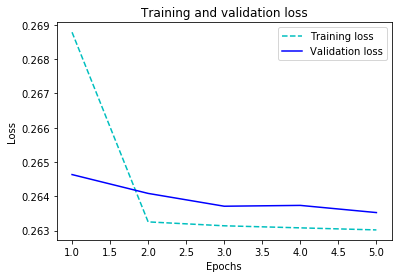

In [31]:
# Visualize loss
viz_loss(history)

### Predicting on Test Datast 

In [42]:
# Reconstruct image using test dataset
decoded_imgs = vae.predict(x_test)

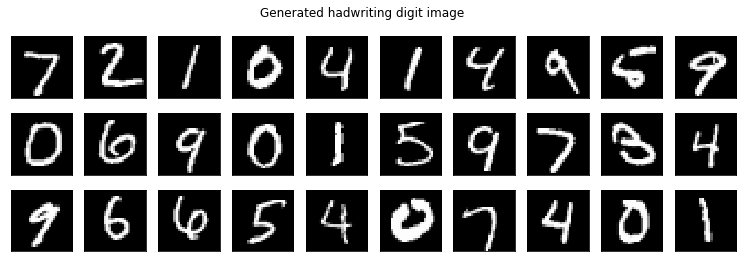

In [43]:
# Show test image

x_test_reshape = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])
visualize_image(x_test_reshape)

In [44]:
# Define visualized image function

def visualize_image(image, row=3, col=10, title='Generated hadwriting digit image'):
    fig, ax = plt.subplots(row,col,figsize=(13,4))
    fig.suptitle(title)
    for i in range(row):
        for j in range(col):
            ax[i,j].imshow(image[j + i*10],cmap='gray')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

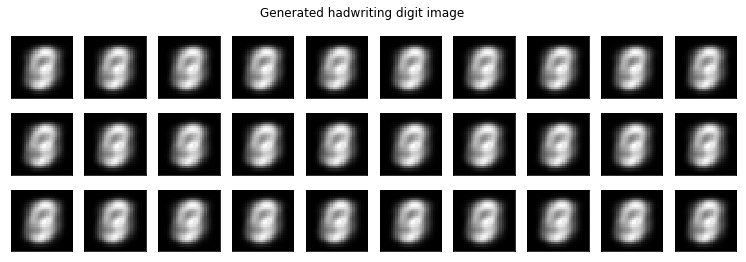

In [45]:
# Show reconstruct image

decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],decoded_imgs.shape[1],decoded_imgs.shape[2])
visualize_image(decoded_imgs)

### Try Randomly Generate Data

In [46]:
# Randomly generate a latent vector

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

random_input = np.random.uniform(high=2,low=-2,size=(64,2))

In [47]:
# Reconstruct image
x_decoded = decoder.predict(random_input, batch_size=batch_size)

In [48]:
# Exploration: X_decode's shape
x_decoded.shape

(64, 28, 28, 1)

In [49]:
# Reshape x_decode
decode_digit = x_decoded.reshape(64,digit_size, digit_size)

### Show Generated Image

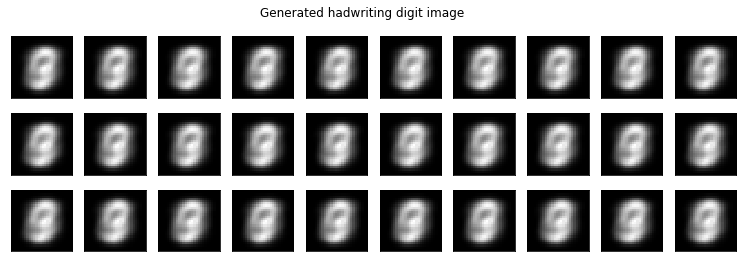

In [50]:
# Show reconstruct image
visualize_image(decode_digit)

### Scan The Latent Space

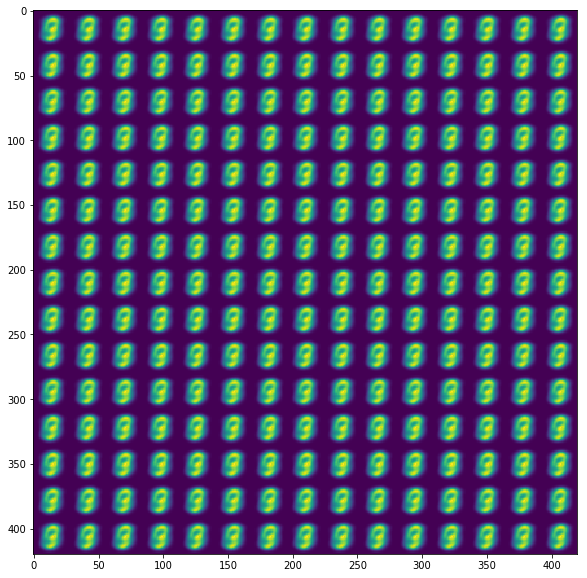

In [51]:
# Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 5e-4
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Visualize Latent Space 

The colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

In [52]:
# Estimate latent space from test set
x_test_encoded = encoder.predict(x_test,batch_size=batch_size)

In [53]:
# Define latent space visualizatio function

def show_latent_space(encoded_imgs):
    plt.figure(figsize=(10, 8))
    plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], 
                c=y_test,alpha=.7, s=3**2, cmap='viridis')
    plt.colorbar()
    plt.show()

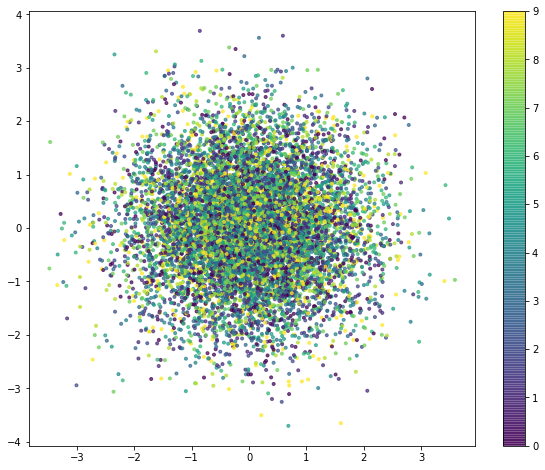

In [54]:
# Show latent space
show_latent_space(x_test_encoded)

## [Optional] To play further with image generation
You can try variational autoencoder model with the following dataset: </br>
1. Cat & Dog https://www.kaggle.com/c/dogs-vs-cats/data </br>
2. Celebrity image (for those who have high computational power) http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html</br>

### More on Autoencoder Model

Autoencoder tutorial: 
1. https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial
2. https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

**Note: Post your work on the facebook using Colab to get an additional point**
